In [1]:
show_plots = True
car_free = False

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.io.display import all_pt_paths, path, pt_path
%matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
# Load the network model from the last exercise
model_path = '../../model/'
input_path = '../../input/'
sm = stepmodel.read_json(model_path + 'network')

In [4]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    sm.__dict__[key] = gpd.GeoDataFrame(sm.__dict__[key], crs=sm.epsg)
broken_gdf_keys = [key for key in sm.__dict__.keys() if type(sm.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in sm.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters']
Successfully fixed.


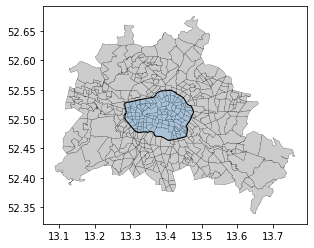

In [5]:
umweltzone = gpd.read_file(input_path + "zones/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=sm.epsg)
umweltzone_geom = umweltzone['geometry'].iloc[0]
if show_plots: umweltzone.plot(color="#2299ff33", edgecolor="black", linewidth=1, ax=sm.zones.plot(color="#cccccc", edgecolor="black", linewidth=0.2))

## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [6]:
sm.road_links.sample(1)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
57141,705908224,21538170,299.509,12954.417479,0.967327,"LINESTRING (13.50775 52.40748, 13.50547 52.40978)",secondary,50,False


In [7]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,road_a,road_b,road_length,geometry,road_node_list,road_link_list
index,,,,,,,,,,,,,,,,,,,
link_8811,17416_900_0,n_node_de:11000:900134512::3,n_node_de:11000:900134513::5,29,60.0,600,17416_900_0,17416_900,1779,1,796,tram,None,1821447987,169492704,NaN,"LINESTRING (13.42980 52.60834, 13.42337 52.60700)",[],[]


In [8]:
# We don't see any length column in our links,
# but it is nice for calculating speeds and for later steps.
# We can cast the PT network onto the road network (as in A40)
# Start with the bus links
bus = sm.copy() # copy the whole model
bus.links = bus.links.loc[bus.links['route_type'].isin(['bus'])] # Filter
# Apply quetzal's casting function
bus.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

17368_700_0: 100%|██████████| 441/441 [02:09<00:00,  3.41it/s]


In [9]:
bus.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,route_color,road_a,road_b,road_node_list,road_link_list,road_length,geometry
index,,,,,,,,,,,,,,,,,,,
link_1652,17300_700_2,n_node_de:11000:900052251::2,n_node_de:11000:900053291::3,25,60.0,1200,17300_700_2,17300_700,1779,0,796,bus,None,26602399,29865388,"[26602399, 26602427, 29865388]","[2005, 2020]",310.551,"LINESTRING (13.18049 52.41890, 13.17729 52.419..."


In [10]:
# Now take the road_length of casted model as the length of our genuine model
sm.links['length'] = np.nan # create a new column with default values
sm.links.loc[sm.links['route_type'].isin(['bus']),
             'length'] = bus.links['road_length']

In [11]:
# For rail links, we can assign the geometric distance
sm.links.loc[sm.links['length'].isna(), 'length'] = \
    sm.links.loc[sm.links['length'].isna(), 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
# Take the geometric line and from it the start and end points, then calculate the meter distance in between

In [12]:
# You can calculate the average bus operation speed
bus = sm.links.loc[sm.links['route_type'] == 'bus'] # filter
bus_lines = bus.groupby('route_id')[['time', 'length']].sum() # sum up time and length for each route
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s', bus_speed*3.6, 'km/h')

bus_speed = 5.124441415003501 m / s 18.447989094012605 km/h


In [13]:
sm.road_links.head(3)

,a,b,length,validation_load,validation_share,geometry,highway,maxspeed,validation_threshold
index,,,,,,,,,
1,172539,34694265,237.653,10379.796248,1.0,"LINESTRING (13.33550 52.56521, 13.33859 52.56428)",tertiary,50,True
2,172539,34694336,687.484,13820.164605,1.0,"LINESTRING (13.33550 52.56521, 13.34515 52.56680)",secondary,50,True
3,172539,3977742457,391.153,19240.567732,1.0,"LINESTRING (13.33550 52.56521, 13.33114 52.56289)",secondary,50,True


## add speed information to road link

#### fixing broken 'maxspeed' column as it contains None, strings not convertable to numbers and lists 

In [14]:
y = 0
a = [item for sublist in \
        [item for sublist in \
            [[[x for n, x in a1 if not x in a2[:n]] \
                for a1, a2 in [(enumerate(sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000]), sm.road_links['maxspeed'].values[y:y+len(sm.road_links)//1000])]] \
            for y in np.array(range(len(sm.road_links)//1000+1))*1000]\
        for item in sublist]\
    for item in sublist]

In [15]:
allHighwayTypes = []

for val in sm.road_links['highway'].values:
    if type(val)==list:
        for v in val:
            if not v in allHighwayTypes:
                allHighwayTypes.append(v)
    elif not val in allHighwayTypes:
        allHighwayTypes.append(val)

print(allHighwayTypes)


['tertiary', 'secondary', 'residential', 'primary', 'primary_link', 'motorway_link', 'motorway', 'unclassified', 'secondary_link', 'trunk_link', 'living_street', 'trunk', 'tertiary_link', 'razed']


In [16]:
realisticSpeedDict={30: 25, 100: 70}
speedReduction = .7

In [17]:
non_valid_speed_str = [None, 'walk','DE:urban']
maxspeed_clean = np.asarray([np.asarray(x).astype(int).mean() if type(x) == list else int(x) for x in sm.road_links['maxspeed'].values if x not in non_valid_speed_str])

maxSpeedByType = {}
effectiveSpeedByType = {}
for key in allHighwayTypes:
    fltrd = maxspeed_clean[[key in x if type(x)==list else x==key for x, y in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values) if y not in non_valid_speed_str]]
    if len(fltrd)>0:
        maxSpeedByType[key] = round(fltrd.astype(int).mean(),2)
        effectiveSpeedByType[key] = maxSpeedByType[key]*speedReduction
    else:     
        maxSpeedByType[key] = 0.1
        effectiveSpeedByType[key] = 0.1
maxSpeedByType

{'tertiary': 45.48,
 'secondary': 47.9,
 'residential': 30.68,
 'primary': 48.54,
 'primary_link': 48.14,
 'motorway_link': 56.78,
 'motorway': 75.58,
 'unclassified': 40.28,
 'secondary_link': 48.88,
 'trunk_link': 48.0,
 'living_street': 25.69,
 'trunk': 51.67,
 'tertiary_link': 47.19,
 'razed': 0.1}

In [18]:
maxspeed_cleaned = np.asarray([np.asarray(mxsp).astype(int).mean()*speedReduction if type(mxsp) == list \
    else np.asarray([effectiveSpeedByType[h] for h in hw]).mean() if type(hw)==list \
    else effectiveSpeedByType[hw] if mxsp in non_valid_speed_str \
    else np.float64(mxsp)*speedReduction \
for hw,mxsp in zip(sm.road_links['highway'].values, sm.road_links['maxspeed'].values)])

sm.road_links['avspeed'] = maxspeed_cleaned

In [19]:
# if show_plots:
#     fig, ax = plt.subplots(nrows=2, figsize = (16,24))
#     sm.road_links.plot(ax=ax.flat[0], cmap="viridis", column=np.array([type(x) for x in sm.road_links['maxspeed']]), linewidth=0.2, legend=True)
#     sm.road_links.plot(ax=ax.flat[1], cmap="Reds", column=maxspeed_cleaned, linewidth=(maxspeed_cleaned/100), legend=True)

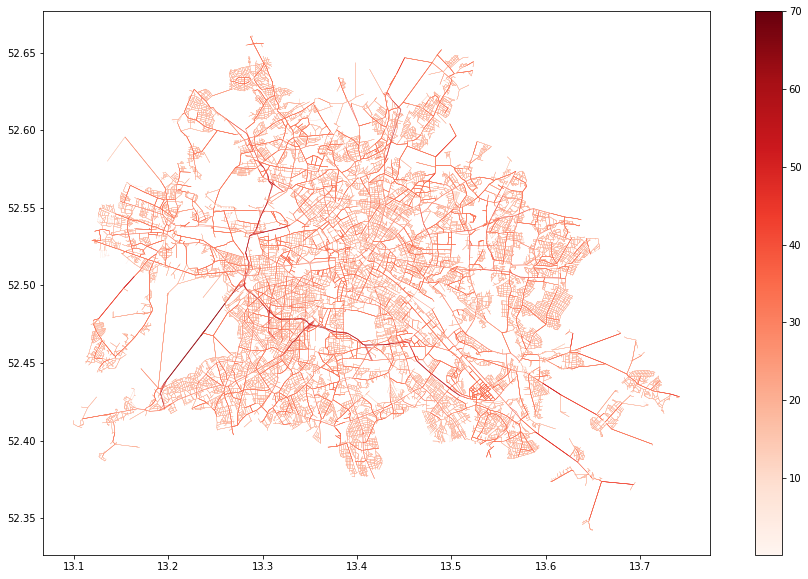

In [20]:
if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize = (16,10))
    sm.road_links.plot(ax=ax, cmap="Reds", column=maxspeed_cleaned, linewidth=(maxspeed_cleaned/100), legend=True)

In [21]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
# car_speed = bus_speed * 1.25
# sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s
sm.road_links['time'] = sm.road_links['length'] / (sm.road_links['avspeed'] *1000/(60**2))

<AxesSubplot:>

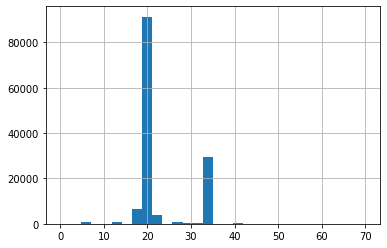

In [22]:
r = sm.road_links['length']/sm.road_links['time']*3.6
r.hist(bins=30)

In [23]:
# If we want to compute walking paths on road links, we need a time for that to
# sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car
sm.road_links['walk_time'] = sm.road_links['length'] / (5/3.6) # walk with 5 km/h per hour
# sm.road_links['bike_time'] = sm.road_links['length'] / (16.5/3.6) #
print('walk_speed', bus_speed * 1.25 / 3 *3.6, 'km/h seems too fast.')

walk_speed 7.686662122505252 km/h seems too fast.


## set umweltzone car free or not

In [24]:
sm_outside = sm.copy()

inside_zone_ids = sm.zones.index.values[sm.centroids.geometry.apply(lambda g: g.within(umweltzone_geom))]
outside_zone_ids = sm.zones.index.values[sm.centroids.geometry.apply(lambda g: not g.within(umweltzone_geom))]

sm_outside.zones = sm_outside.zones[[i in outside_zone_ids for i in sm_outside.zones.index.values]].copy() 
sm_outside.centroids = sm_outside.centroids[[i in outside_zone_ids for i in sm_outside.centroids.index.values]].copy()
sm_outside.road_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] == 'motorway' or not row['geometry'].intersects(umweltzone_geom), axis=1)].copy()
sm_outside.zone_to_road = sm_outside.zone_to_road[sm_outside.zone_to_road.apply(lambda row: row['a'] in outside_zone_ids or row['b'] in outside_zone_ids, axis=1)].copy()

In [25]:
# set ['highway'] != 'motorway'because stadtautobahn intersects umweltzone eventhough it should be considered completly outside
inside_road_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] != 'motorway' and row['geometry'].intersects(umweltzone_geom), axis=1)]
inside_outside_connection_links = sm.road_links[sm.road_links.apply(lambda row: row['highway'] != 'motorway' and row['geometry'].crosses(umweltzone_geom), axis=1)]

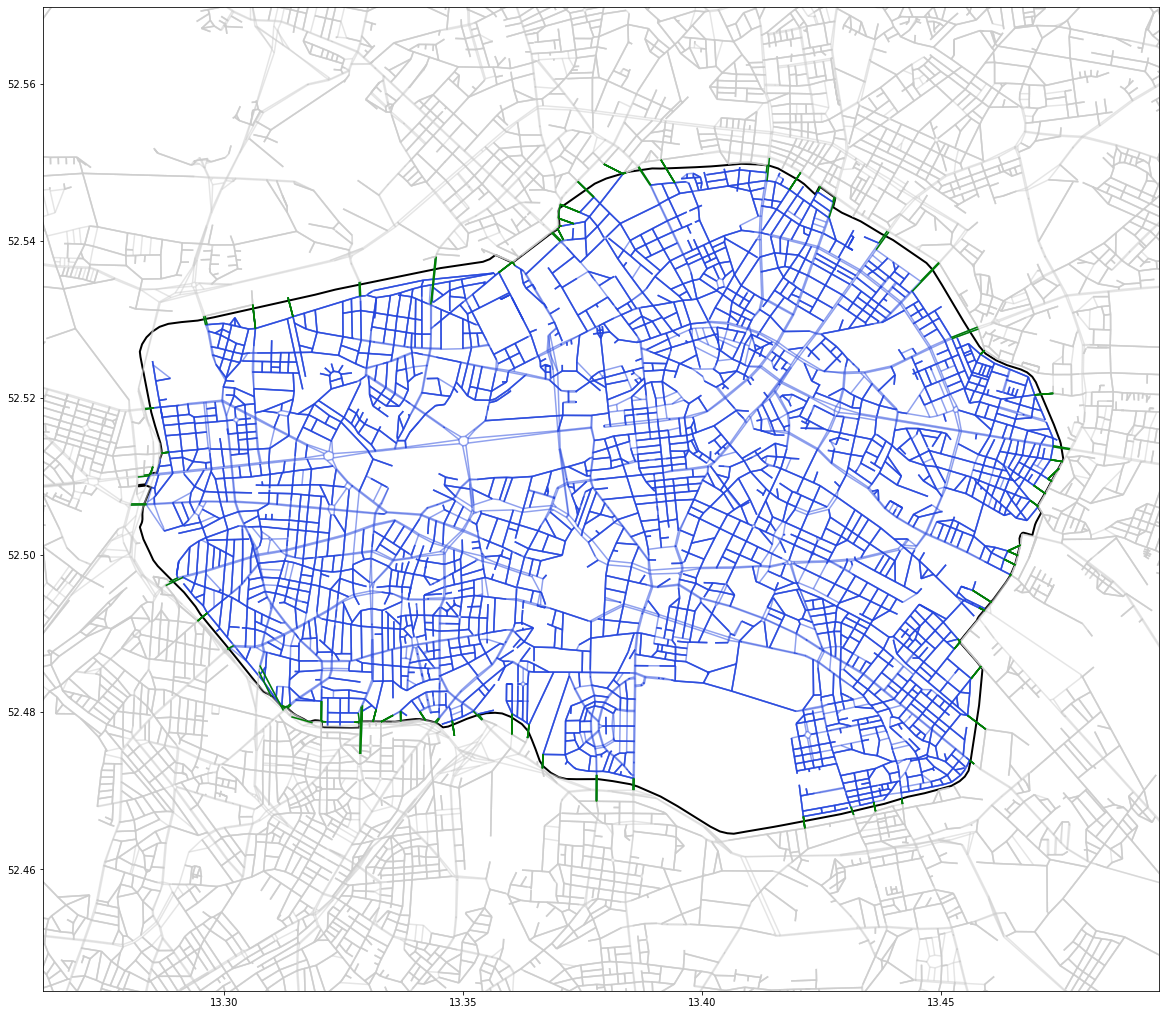

In [26]:

if show_plots:
    fig, ax = plt.subplots(nrows=1, figsize = (20,20))
    inside_road_links.plot(ax=ax, color="#2244dd", alpha=.5)
    sm_outside.road_links.plot(ax=ax, color="#cccccc", alpha=.5)
    inside_outside_connection_links.plot(ax=ax, color='green', linewidth=1.5)
    umweltzone.plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    ax.set_xlim(umweltzone.total_bounds[0]-0.02, umweltzone.total_bounds[2]+0.02)
    ax.set_ylim(umweltzone.total_bounds[1]-0.02, umweltzone.total_bounds[3]+0.02)



## Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`)

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

### Car

In [27]:
# Simple road pathfinder # broken_modes=False, broken_routes=False
sm.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
sm.analysis_car_route_type()

sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
88262,zone_05030833,zone_01011202,1584.166492,"[zone_05030833, 28321448, 33484094, 33484095, ...","[28321448, 33484094, 33484095, 33484092, 30564...","[14161, 30574, 30577, 131476, 68652, 5763, 575...","[(zone_05030833, 28321448), (1864428537, zone_...",11687.462,"(car,)",car


In [28]:
# for car free scenario
sm_outside.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm_outside.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm_outside.car_los['length'] = sm_outside.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
sm_outside.analysis_car_route_type()

sm_outside.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
17113,zone_04020314,zone_07060602,1717.055854,"[zone_04020314, 268095463, 26746007, 267286252...","[268095463, 26746007, 267286252, 26662407, 231...","[48349, 4997, 48187, 2402, 67245, 2453, 4198, ...","[(zone_04020314, 268095463), (32349231, zone_0...",14620.623,"(car,)",car


## PT step_pt_pathfinder

In [29]:
# Simple PT
# set broken_modes=False because for our model unique best path matters. no capacity constrained involved anyways.
sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)


path_analysis: 100%|██████████| 200704/200704 [00:12<00:00, 15681.29it/s]


In [30]:
sm_pt_los, sm_links = sm.pt_los.copy(), sm.links.copy()

## Bike

In [31]:
bike_speed = 16.5#km/h /3.6 #m/s
bk, bk_road_links = sm.copy(), sm.road_links.copy()

# road network excluding high ways etc.
bk_road_links = bk_road_links[bk_road_links['avspeed']/0.7 <= 50]
bk_road_links['walk_time'] = bk_road_links['walk_time'] * 7 / bike_speed # lonleg speed / bike speed, as you dont have to walk to start point.
bk_road_links['time'] = bk_road_links['length'] / (bike_speed/3.6)

bk.road_links = bk_road_links
bk.car_los = bk.car_los.copy()

# Simple road pathfinder # broken_modes=False, broken_routes=False
bk.step_road_pathfinder(all_or_nothing=True)

# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = bk.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
bk.car_los['length'] = bk.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

# add the route type for sake of consistency
bk.analysis_car_route_type()
bk.car_los['route_type'] = 'bike'
bk.car_los['route_types'] = [('bike',) for x in range(len(bk.car_los))]

## rebuild bike object to fit to fit in PT structurem

### rebuild links object for bikes from car_los, road_nodes, (road_links)

In [32]:
bk_links = bk.car_los.copy()

# id names don't match link format (link format use nodes based on stop_ids instead of zone ids) 
bk_links['origin'] = bk_links['origin'] # maybe use node here
bk_links['destination'] = bk_links['destination'] # maybe use nodes here
bk_links['pattern_id'] = 'bike_' + bk_links['origin'] + '_' + bk_links['destination']
bk_links['trip_id'] = bk_links['pattern_id'] + '_0'
bk_links['route_id'] = bk_links['trip_id']

bk_links['a'] = bk_links['origin']
bk_links['b'] = bk_links['destination']
bk_links['road_node_list'] = bk_links['node_path']
bk_links['road_links_list'] = bk_links['link_path'] 

bk_links['road_a'] = [x[0] if len(x)>0 else None for x in bk_links['road_node_list']]
bk_links['road_b'] = [x[-1] if len(x)>0 else None for x in bk_links['road_node_list']]

bk_links['duration'] = bk_links['time']

# make geometry LineString connecting all road_nodes (not precisely mapping on road)
# bk_links['geometry'] = [LineString([bk.road_nodes.loc[l].geometry for l in node_path ]) for node_path in bk_links['node_path']] 
# save time by just using straight line connection
bk_links['geometry'] = [LineString([bk.road_nodes.loc[l].geometry for l in [node_path[0], node_path[-1]] ]) if len(node_path)>0 else LineString([]) for node_path in bk_links['node_path']] 

bk_links['link_sequence'] = [len(x) for x in bk_links['road_links_list']] # unsure about that one.

bk_links['headway'] = 0 # set to number so that headway is super small. you can always start your bike trip
bk_links['cost'] = bk_links['time'] # cost = time + .5 * headway

bk_links['route_type'] = 'bike'

bk_links['service_id'] = 0
bk_links['direction_id'] = 1
bk_links['agency_id'] = 0
bk_links['color'] = None

bk.links = bk.links[0:0] # clear previous links
bk.links = bk.links.append(bk_links)
bk.links.index = 'bike_' + bk.links.index.astype(str).values


### rebuild pt_los object for bikes from car_los, road_nodes, (road_links)


In [33]:
bike_los = bk.car_los # .copy()

bike_los['gtime'] = bike_los['time']

bike_links_t_id_dict = dict([(t_id, i) for i, t_id in zip(bk_links.index, bk_links['trip_id'].values)])
bike_los['link_path'] = [['bike_' + str(bike_links_t_id_dict['bike_' + o + '_' + d + '_0'])] if o != d else [] for o,d in zip(bike_los['origin'].values, bike_los['destination'].values)]
# bike_los['link_path'] = [['bike_' + str(l) for l in p] for p in bike_los['link_path']]

# bike_los['route_type'] = 'bike'
# bike_los['route_types'] = (bike_los['route_type'],)

bike_los['reversed'] = False
bike_los['pathfinder_session'] = 'mode_breaker'

bike_los['broken_modes'] = [{} for x in range(len(bike_los))]
bike_los['boardings'] = [[] for x in range(len(bike_los))]
bike_los['alightings'] = [[] for x in range(len(bike_los))]
bike_los['transfers'] = [[] for x in range(len(bike_los))]
bike_los['boarding_links'] = [[] for x in range(len(bike_los))]
bike_los['alighting_links'] = [[] for x in range(len(bike_los))]
bike_los['ntlegs'] = [[] for x in range(len(bike_los))]
bike_los['footpaths'] = [[] for x in range(len(bike_los))]

bike_los['all_walk'] = False
bike_los['ntransfers'] = 0


bike_los['time_link_path'] = bike_los['time']
bike_los['length_link_path'] = bike_los['length']

# bike_los['footpaths'] = (sm.zone_to_road[sm.zone_to_road['a']==a] for a in bike_los['a'])

bike_los.index = 'bike_' + bike_los.index.astype(str).values

### join bike to pt tables

In [34]:
sm.pt_los = sm_pt_los
# append bike type to pt_los
clmns = [x for x in sm.pt_los.columns if x in bike_los.columns]
print(clmns)
if 'route_type' in clmns:
    sm.pt_los = sm.pt_los[sm.pt_los['route_type'] != 'bike']
sm.pt_los = sm.pt_los.append(bike_los[clmns])

# append bike type and to links
sm.links = sm.links[sm.links['route_type'] != 'bike']
sm.links = sm.links.append(bk.links)

print(len(sm.pt_los))
# 2 130 868
# 2 130 247

['origin', 'destination', 'gtime', 'path', 'pathfinder_session', 'reversed', 'boardings', 'alightings', 'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers', 'boarding_links', 'alighting_links', 'all_walk', 'ntransfers', 'time_link_path', 'length_link_path']
398732


### get pt statistics

In [35]:
sm.links['route_type'].unique()
# to-do bikes need to be added to links!

array(['bus', 'rail', 'tram', 'subway', 'bike'], dtype=object)

In [36]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['bike', 'rail', 'subway', 'funicular', 'tram', 'bus']
sm.analysis_pt_route_type(hierarchy)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

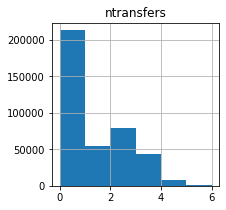

In [37]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=sm.pt_los['ntransfers'].max(), figsize=(3,3))

In [38]:
#('bus',) in  
sm.pt_los['route_types'].unique()

array([(), ('bus', 'subway'), ('bus',), ('rail', 'bus'),
       ('rail', 'bus', 'subway'), ('bus', 'tram'),
       ('rail', 'bus', 'tram'), ('rail', 'bus', 'subway', 'tram'),
       ('bus', 'subway', 'tram'), ('subway',), ('rail', 'subway'),
       ('rail',), ('rail', 'tram'), ('rail', 'subway', 'tram'),
       ('subway', 'tram'), ('tram',), ('bike',)], dtype=object)

<AxesSubplot:xlabel='route_types'>

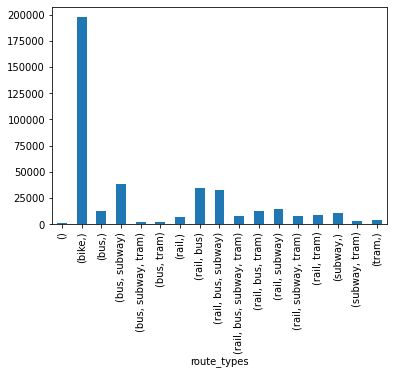

In [39]:
# How many connections do we have per mode combination in the shortest paths?
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [40]:
# Now, let's look at the results when we disaggregate paths by route_type
# sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)

In [41]:
# How many paths do we have now compared to 12,100 before?
len(sm.pt_los)

398732

In [42]:
sm.analysis_pt_route_type(hierarchy)
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
bike_110323,zone_07010103,zone_04020209,1969.398878,"[zone_07010103, 311205843, 27784958, 27784959,...",mode_breaker,False,[],[],"[311205843, 27784958, 27784959, 248527285, 277...",[bike_110323],...,[],[],[],[],False,0,1969.398878,7543.54,"(bike,)",bike


<AxesSubplot:xlabel='route_types'>

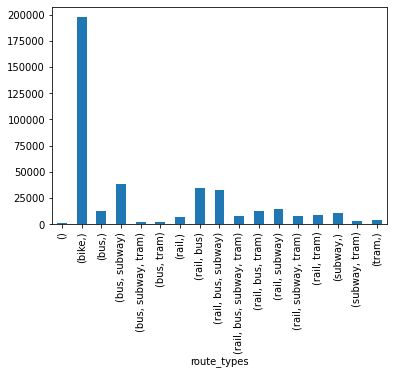

In [43]:
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

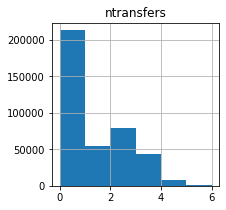

In [44]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=6, figsize=(3,3))

In [45]:
sm.pt_los.tail(2)

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
bike_200702,zone_12304314,zone_12304313,486.336261,"[zone_12304314, 168209206, 168209213, 24871861...",mode_breaker,False,[],[],"[168209206, 168209213, 248718618, 338891124, 1...",[bike_200702],...,[],[],[],[],False,0,486.336261,1779.592,"(bike,)",bike
bike_200703,zone_12304314,zone_12304314,0.000000,[zone_12304314],mode_breaker,False,[],[],[],[],...,[],[],[],[],False,0,0.000000,0.000,(),bus


In [46]:
sm.pt_los.head(2)


,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
0,zone_01011101,zone_01011101,0.000000,"(zone_01011101,)",best_path,False,[],[],[],[],...,[],[],[],[],True,0,0.0,0.00,(),bus
1,zone_01011101,zone_01011102,1531.562745,"(zone_01011101, n_node_de:11000:900005101::1, ...",best_path,False,"[n_node_de:11000:900005101::1, n_node_de:11000...","[n_node_de:11000:900023201::6, n_node_de:11000...","[n_node_de:11000:900005101::1, n_node_de:11000...","[link_5919, link_5920, link_12185]",...,"[(zone_01011101, n_node_de:11000:900005101::1)...",[],"[link_5919, link_12185]","[link_5920, link_12185]",False,1,360.0,2535.32,"(bus, subway)",subway


In [47]:
# Compute time attribute (from link path and footpaths and access links)
sm.analysis_pt_time()

In [48]:
# Closer look at one OD pair
sm.pt_los.loc[(sm.pt_los['origin']=='zone_11') & (sm.pt_los['destination']=='zone_99')][
    ['route_types', 'time', 'ntransfers']]

,route_types,time,ntransfers


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


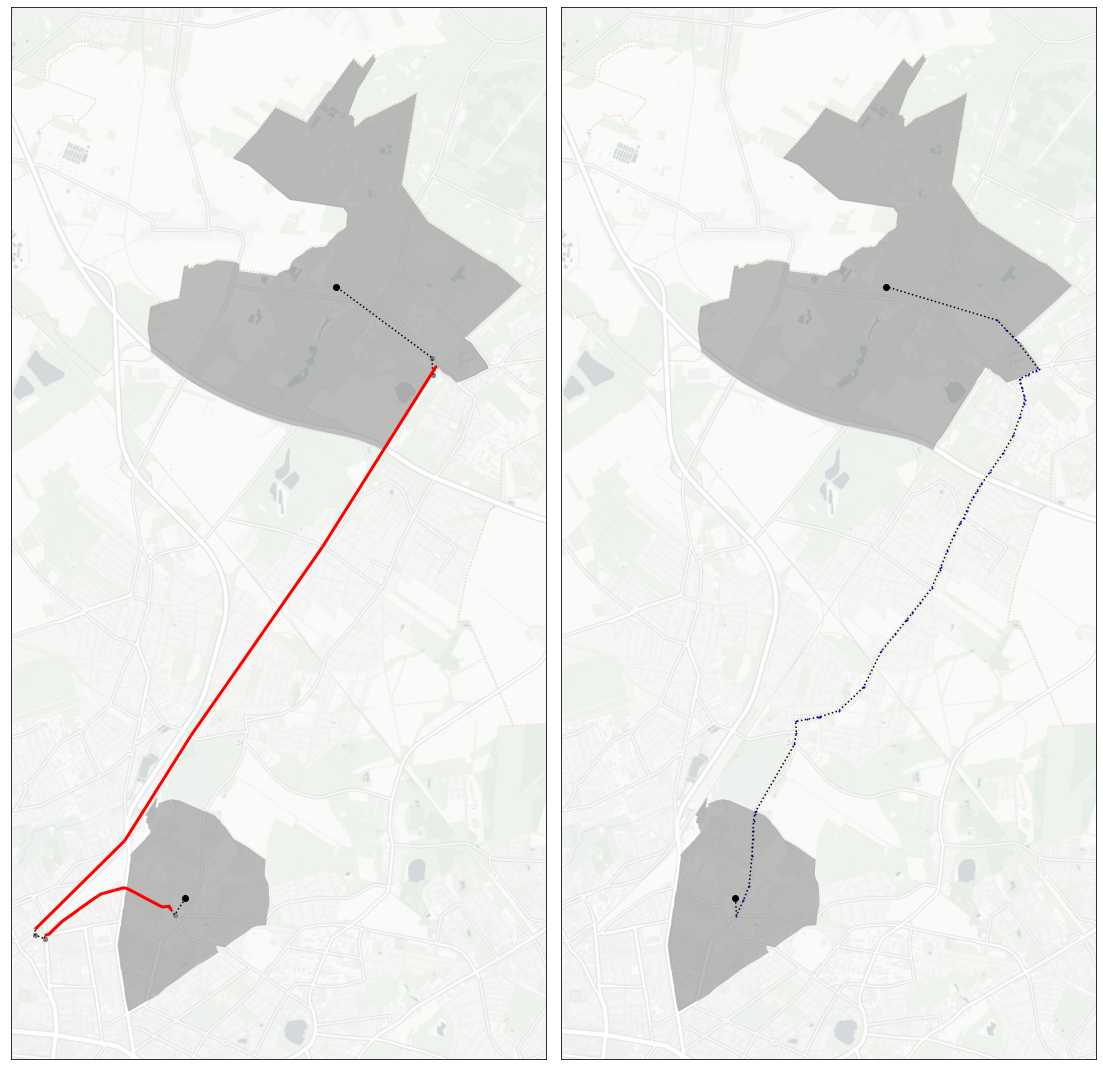

In [49]:
# Plot
if show_plots:
    plot = sm.change_epsg(3857, coordinates_unit=sm.coordinates_unit)
    plot.links['color'] = '#' + plot.links['route_color']
    fig, axes = plot.plot_separated_paths(
        sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], rows=1, figsize=[16, 16],
        title=None, constrained_layout=True, zoom=13, resize=True,
        basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
    )

In [50]:
# Assign a length to LoS table
sm.analysis_pt_length()

<AxesSubplot:>

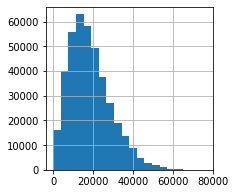

In [51]:
# Length distribution
sm.pt_los['length'].hist(bins=20, figsize=(3,3))

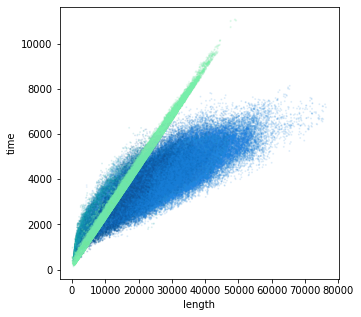

In [52]:
# Dependency between distance and time
mask = sm.pt_los['origin']!=sm.pt_los['destination'] # Filter statement
color_dict = {'bus': '#129eac', 'subway': '#0e5899', 'tram': '#5ea8e8', 'rail': '#1F85DE', 'walk': '#adb3b4', 'bike': '#77eeaa'}
color_list = [color_dict[t] for t in sm.pt_los.loc[mask, 'route_type']]
ax = sm.pt_los.loc[mask].plot(
    kind='scatter', x='length', y='time', figsize=[5, 5], s=1, c=color_list, alpha=.1, legend=True)

In [53]:
sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)]

('zone_03030715', 'zone_03010101')

In [54]:
# Plot all paths between zones including car
if show_plots:
    path(sm, sm.zones.index[77%len(sm.zones)], sm.zones.index[67%len(sm.zones)], public=True, private=True)

## append both scenarios to car_los

In [55]:
sm_outside.car_los['scenario'] = 'car_free'
sm_outside.car_los.index = 'car_free_' + sm_outside.car_los.index.astype(str).values
sm.car_los['scenario'] = 'cars'
sm.car_los = sm.car_los.append(sm_outside.car_los)

## Save model

In [56]:
sm.pt_los.reset_index(drop=True, inplace=True)

In [57]:
sm.to_json(model_path + 'los_tables')

to_hdf(overwriting):  79%|███████▉  | 30/38 [05:34<00:09,  1.15s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


to_hdf(overwriting): 100%|██████████| 38/38 [06:16<00:00,  9.90s/it]
